## MIT-BIH Arrhythmia Database



The MIT-BIH Arrhythmia Database contains: 
* 48 half-hour (30 min) recordings
* two-channel  
* from 47 subjects

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import scipy.io
import scipy
import pickle

! pip install wfdb
import wfdb

! pip install findpeaks
import findpeaks

from scipy import signal
from sklearn.preprocessing import minmax_scale
from scipy.signal import find_peaks, resample
import statistics

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')


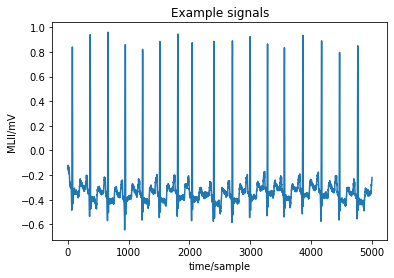

In [12]:
path = "/content/drive/MyDrive/ECG_classification_project/mit-bih-arrhythmia-database"
filename = os.path.join(path, "100")

record = wfdb.rdrecord(filename, sampfrom=0, sampto=5000, channels=[0])
wfdb.plot_wfdb(record=record, title='Example signals')

In [13]:
def write_beat(filename, beat):
  with open(filename, 'wb') as fp:
    pickle.dump(beat, fp)

Preprocessing involves removing the baseline, motion artifacts,
and other interruptions of the original recorded signal. 

In [125]:
class Processing:
  
  def __init__(self, input_path, output_path):
    
    self.input_path = input_path
    self.output_path = output_path   
    self.records = [] 
    self.annotations = []
    self.num_beats = 0

  def get_all_records(self):

    """ From the file RECORDS takes record names and puts them into a list """

    # Get all records from the database
    filename = os.path.join(self.input_path, "RECORDS")

    with open(filename) as f:
      lines = f.readlines()

    for line in lines:
      self.records.append(line[:-1])    # Skip the last part because it is a new line sign '\n' 

    f.close()

    # Get all annotations from the database
    filename_ann = os.path.join(self.input_path, "ANNOTATORS")

    with open(filename_ann) as f:
      lines = f.readlines()

    for line in lines:
      self.annotations.append(line.split()[0])    # Skip the last part because it is a new line sign '\n' 

    f.close()


  def get_signal(self, filename, ext, plot = False, ch = 0):
    
    """ Given the filename, extension of the annotation file, channel number 
        returns an annotation objest and reads/converts signal into a numpy 
        array. In case you want to plot the signal put plot = True """

    filename_path = os.path.join(self.input_path, filename)

    if os.path.exists(filename_path + '.' + ext) == True:

      # Take one file and take its first lead ECG1
      record = wfdb.rdrecord(filename_path, sampfrom = 0, channels = [ch])

      if plot == True:
        wfdb.plot_wfdb(record=record, title='Example signals')

      # Take this signal's annotations
      annot = wfdb.rdann(filename_path, sampfrom = 0, extension = ext)

      # Convert signal into numpy array
      record_arr = np.array(record.p_signal)
      self.fs = annot.fs

      return record_arr, annot

    else:
      return 0, 0

  def downsample(self, signal_orig, ann, fs_new = 125):
    
    """ Given the signal and its annotation downsample the signal and 
        modify the positions of the annotations 
    """

    fs = self.fs
    positions = ann.sample
    
    new_num_samples = int(len(signal_orig)/fs*fs_new)
    downsamp_signal = np.array(resample(signal_orig, new_num_samples))
    
    downsamp_ann = positions/(fs/fs_new)
    downsamp_ann = np.round(downsamp_ann).astype(int)

    return downsamp_signal, downsamp_ann

  def normalization(self, down_signal):
    
    """ Given the signal, returns the normalized one with value range [0, 1] """

    norm_signal = minmax_scale(down_signal, feature_range=(0, 1), axis=0, copy=True)
    return norm_signal

  def R_peak_detection(self, norm_signal, thresh = 0.9):
    
    """ Given the signal and the threshold returns the positions of """

    norm_signal = norm_signal[:,0]
    T = thresh*max(norm_signal)
    R_peaks, _ = find_peaks(norm_signal, T)  
    self.R_peaks = R_peaks
    return R_peaks

  def period_duration_estimation(self, R_peaks):
    
    """ Given the array of R peak positions in the signal, computes the duration
        between sucessive R peaks and the median value - period T estimation 
    """
    
    # RR peak variation 
    RR_periods = []
    for i in range(0,len(R_peaks)-1):
      RR_periods.append(R_peaks[i+1]-R_peaks[i])

    # Median of RR periods
    RR_median = statistics.median(RR_periods) 
    self.aprox_period = RR_median

  def signal_to_beats(self, signal, ann, down_ann, R_peaks):

    """ Given the signal and its annotations, extract 
        only beats labeled as N, S, V, F and Q 
    """

    D = self.aprox_period                           # Duration of all beats
    symbols = ann.symbol                            # Symbol for assigned beat         
    ann_positions = down_ann                        # Beat positions
    label_set = {'N', 'S', 'V', 'F', 'Q'}           # Labels

    for i, peak_position in enumerate(R_peaks):    
      label_idx = np.argmax(-abs(ann_positions-peak_position))
      label = symbols[label_idx]

      if label in label_set:        
        if peak_position-int(D/2)<0:
          beat = signal[0:peak_position+int(D/2)]      
        elif peak_position+int(D/2)>len(signal)-1:
          beat = signal[peak_position-int(D/2):len(signal)-1] 
        else:
          beat = signal[peak_position-int(D/2):peak_position+int(D/2)] 

        # Write each beat giving it a name as order number
        data_output = os.path.join(self.output_path, 'data', str(self.num_beats))
        
        label_output = os.path.join(self.output_path, 'labels', str(self.num_beats))
        write_beat(data_output, beat)
        write_beat(label_output, label)

        self.num_beats += 1

        self.dataset.append(beat)
        self.dataset_labels.append(label)

  def make_dataset(self):

    """ 1. Read the signal and its annotations
        2. Preporocessing (downsample, normalize, extract R peaks)
        3. Estimate the period T or heart rate
        4. Split signal into beat of duration T
    """

    self.dataset = []
    self.dataset_labels = []

    for record in self.records:
      for channel in [0, 1]:
        
        # Get the signal and its annotation object
        signal, ann = self.get_signal(record, 'atr', False, channel)       
        if isinstance(signal, np.ndarray) == False:
          continue

        # Signal preprocessing 
        down_samp, down_ann = self.downsample(signal, ann)
        norm_sig = self.normalization(down_samp)
        R_peaks = self.R_peak_detection(norm_sig)
  
        if len(R_peaks)<2:
          continue
          
        self.period_duration_estimation(R_peaks)

        # Get beats labeled with N, S, V, F and Q from the signal
        self.signal_to_beats(norm_sig, ann, down_ann, R_peaks)

    #df_dataset = pd.DataFrame(list(map(np.ravel, self.dataset)))
    #df_labels = pd.DataFrame(dataset_labels)

    #df_dataset.to_csv(self.output_path + '/' + 'dataset.csv')
    #df_labels.to_csv(self.output_path + '/' + 'labels.csv')



In [ ]:
input_path = "/content/drive/MyDrive/ECG_classification_project/mit-bih-arrhythmia-database"
output_path = "/content/drive/MyDrive/ECG_classification_project/Dataset"

processing = Processing(input_path, output_path)
processing.get_all_records()

# Extract the beats labeled with N, S, V, F and Q only
processing.make_dataset()

In [ ]:
# Return signal as a nparray and the annotation object
signal, ann = processing.get_signal(
    processing.records[0], 
    processing.annotations[0], 
    plot = False
    )

# Downsample the signal (defaul frequency is 125Hz)
downsampled_signal = processing.downsample(signal, ann)

# Normalize the signal -> values [0, 1]
normalized_signal = processing.normalization(downsampled_signal)

# Find R peaks and estimating the period
R_peaks = processing.R_peak_detection(normalized_signal)
T_estim = processing.period_duration_estimation(R_peaks)
